In [9]:
import json
import math
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import hdbscan
import requests

In [13]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Compute the haversine distance between two (lat, lon) pairs in kilometers."""
    R = 6371.0  # Earth radius in kilometers
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


def parse_location_history(file_path, time_threshold=30):
    """Parse the JSON file and extract 'visit' entries with a duration above the threshold.
       Expected location format is a string like 'geo:38.029210,-78.508736'."""
    with open(file_path, 'r') as f:
        data = json.load(f)

    records = []
    for entry in data:
        if "visit" in entry:
            visit = entry["visit"]
            if "topCandidate" in visit and "placeLocation" in visit["topCandidate"]:
                loc_str = visit["topCandidate"]["placeLocation"]
                if loc_str.startswith("geo:"):
                    try:
                        lat_str, lon_str = loc_str[4:].split(',')
                        lat = float(lat_str)
                        lon = float(lon_str)
                    except Exception:
                        continue
                else:
                    continue

                try:
                    start_time = datetime.fromisoformat(entry["startTime"].replace("Z", "+00:00"))
                    end_time = datetime.fromisoformat(entry["endTime"].replace("Z", "+00:00"))
                except Exception:
                    continue

                duration = (end_time - start_time).total_seconds() / 60.0  # minutes
                if duration >= time_threshold:
                    records.append({
                        'latitude': lat,
                        'longitude': lon,
                        'start_time': start_time,
                        'end_time': end_time,
                        'duration': duration
                    })
    return pd.DataFrame(records)


def cluster_locations(df, min_cluster_size=3, cluster_epsilon=0.0001):
    """Cluster the locations using HDBSCAN with the haversine metric. Coordinates must be in radians for the haversine metric."""
    coords = df[['latitude', 'longitude']].to_numpy()
    coords_rad = np.radians(coords)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                metric='haversine',
                                cluster_selection_epsilon=cluster_epsilon)
    cluster_labels = clusterer.fit_predict(coords_rad)
    df['cluster'] = cluster_labels
    return df, clusterer


def merge_cluster_summary(df):
    """Compute cluster-level summary statistics for all clusters and merge them back to the raw records."""
    summary = df.groupby('cluster').agg(
        visit_count=('duration', 'size'),
        average_duration=('duration', 'mean'),
        center_latitude=('latitude', 'median'),
        center_longitude=('longitude', 'median')
    ).reset_index()

    # Compute the range for each cluster (for noise, range is set to 0)
    ranges = []
    for c in summary['cluster']:
        if c == -1:
            r = 0.0
        else:
            group = df[df['cluster'] == c]
            center_lat = summary.loc[summary['cluster'] == c, 'center_latitude'].values[0]
            center_lon = summary.loc[summary['cluster'] == c, 'center_longitude'].values[0]
            # Compute the haversine distance for each point in the cluster to the center
            dists = group.apply(lambda row: haversine_distance(center_lat, center_lon, row['latitude'], row['longitude']), axis=1)
            r = dists.max()
        ranges.append(r)
    summary['cluster_range_km'] = ranges
    merged = df.merge(summary, on='cluster', how='left')
    return merged


def query_place_api(lat, lon, api_key=None):
    """Query the Google Maps Reverse Geocoding API for a human-readable address and a location name."""
    if api_key is None:
        # Return placeholder strings if no API key is provided
        address = f"Address_{lat:.3f}{lon:.3f}"
        location_name = f"Place{lat:.3f}_{lon:.3f}"
        return address, location_name

    endpoint_url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {
        "latlng": f"{lat},{lon}",
        "key": api_key
    }
    response = requests.get(endpoint_url, params=params)

    if response.status_code == 200:
        data = response.json()
        if data.get('results'):
            first_result = data['results'][0]
            address = first_result.get('formatted_address', "Unknown Address")

            # Try to extract a location name from address components (e.g., point_of_interest)
            location_name = None
            for component in first_result.get('address_components', []):
                if "point_of_interest" in component.get('types', []):
                    location_name = component.get('long_name')
                    break

            if location_name is None:
                location_name = address
            return address, location_name
    return "Unknown Address", "Unknown Place"


def add_cluster_labels(merged_df, api_key=None):
    """For each unique cluster, query the API (or use placeholders) to get an address and a location name."""
    clusters = merged_df['cluster'].unique()
    label_map = {}
    address_map = {}

    for cluster in clusters:
        if cluster == -1:
            label_map[cluster] = "Noise"
            address_map[cluster] = "Noise"
        else:
            subset = merged_df[merged_df['cluster'] == cluster]
            lat = subset['center_latitude'].iloc[0]
            lon = subset['center_longitude'].iloc[0]
            address, location_name = query_place_api(lat, lon, api_key)
            label_map[cluster] = location_name
            address_map[cluster] = address

    merged_df['location_name'] = merged_df['cluster'].map(label_map)
    merged_df['address'] = merged_df['cluster'].map(address_map)
    merged_df['label'] = merged_df['location_name']  # For compatibility with previous naming
    return merged_df


def save_csv(merged_df, output_file='significant_places_three.csv'):
    """Save the detailed data (all individual significant locations with their aggregated cluster metrics, labels, addresses, and location names) to a CSV file."""
    merged_df.to_csv(output_file, index=False)
    print(f"Saved detailed significant locations to {output_file}")


def plot_static_map(merged_df, filename="static_map"):
    """Generate a static scatter plot of aggregated cluster centers using matplotlib."""
    unique_clusters = merged_df.drop_duplicates(subset=['cluster'])
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    for _, row in unique_clusters.iterrows():
        cluster = row['cluster']
        if cluster == -1:
            continue  # Skip noise for range plotting
        center_lat = row['center_latitude']
        center_lon = row['center_longitude']
        visits = row['visit_count']
        avg_duration = row['average_duration']
        label_text = row['label']
        cluster_range = row['cluster_range_km']

        # Plot the center
        plt.scatter(center_lon, center_lat, s=100, label=f"Cluster {cluster}: {label_text}\nVisits: {visits}, Avg: {avg_duration:.1f} min")
        plt.text(center_lon, center_lat, label_text, fontsize=9, ha='right')

        # Plot a circle to represent the cluster range
        radius_deg = cluster_range / 111.0  # Approximate conversion from km to degrees
        circle = plt.Circle((center_lon, center_lat), radius_deg, color='r', fill=False, linestyle='--', alpha=0.6)
        ax.add_patch(circle)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Aggregated Significant Locations with Cluster Range")
    plt.legend()
    plt.savefig(f"{filename}.png")
    plt.show()
    print(f"Static map saved as {filename}.png")


def plot_interactive_map(merged_df, filename = "interactive_map"):
    """Generate an interactive map with folium."""
    if not merged_df.empty:
        map_center = [merged_df['latitude'].mean(), merged_df['longitude'].mean()]
    else:
        map_center = [0, 0]

    m = folium.Map(location=map_center, zoom_start=12)

    # Add markers and circles for aggregated cluster centers
    unique_clusters = merged_df.drop_duplicates(subset=['cluster'])
    for _, row in unique_clusters.iterrows():
        cluster = row['cluster']
        if cluster == -1:
            continue  # Optionally, skip noise points for circle display
        center_lat = row['center_latitude']
        center_lon = row['center_longitude']
        visits = row['visit_count']
        avg_duration = row['average_duration']
        cluster_range = row['cluster_range_km']
        label_text = row['label']
        address = row['address']
        popup_text = (
            f"Cluster {cluster}: {label_text}<br>"
            f"Address: {address}<br>"
            f"Visits: {visits}<br>"
            f"Avg Duration: {avg_duration:.1f} min<br>"
            f"Range: {cluster_range:.2f} km"
        )
        folium.Marker(
            location=[center_lat, center_lon],
            popup=popup_text,
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)

        # Draw a circle representing the cluster range (convert km to meters)
        folium.Circle(
            location=[center_lat, center_lon],
            radius=cluster_range * 1000,
            color='red',
            fill=False,
            dash_array='5, 5'
        ).add_to(m)

    # Add heatmap of all individual significant points
    heat_data = merged_df[['latitude', 'longitude']].values.tolist()
    HeatMap(heat_data).add_to(m)

    m.save(f"{filename}.html")
    print(f"Interactive map saved as {filename}.html")

Found 39 significant stay points.


C:\Users\prath\PycharmProjects\cs4501Project1\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\prath\PycharmProjects\cs4501Project1\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saved detailed significant locations to significant_places.csv


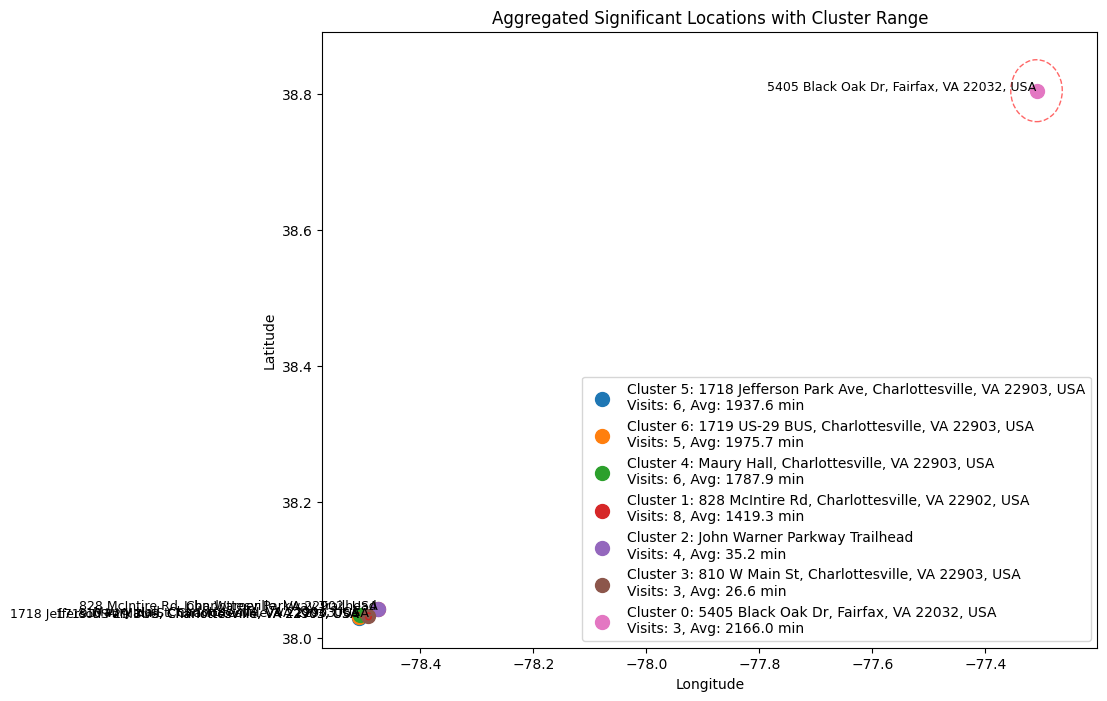

Static map saved as static_map.png
Interactive map saved as interactive_map.html


In [15]:
import os
from dotenv import load_dotenv

if __name__ == "__main__":
    
    load_dotenv()
    # Parameter tuning (adjust as needed)
    TIME_THRESHOLD = 15  # minutes
    MIN_CLUSTER_SIZE = 2
    CLUSTER_EPSILON = 0.000001  # Reduces the effective radius of each cluster (in radians)

    # Optionally, set your Google Maps API key (or leave as None to use placeholder values)
    API_KEY = os.getenv("GOOGLE_PLACES_API_KEY")  # Replace with your API key if desired

    # Parse the location history JSON file.
    df = parse_location_history("location-history.json", time_threshold=TIME_THRESHOLD)
    if df.empty:
        print("No significant stays found based on the given time threshold.")
    else:
        print(f"Found {len(df)} significant stay points.")

    # Cluster the locations with a reduced radius.
    df, clusterer = cluster_locations(df, min_cluster_size=MIN_CLUSTER_SIZE, cluster_epsilon=CLUSTER_EPSILON)

    # Merge the cluster-level summary statistics back onto each individual record.
    merged_df = merge_cluster_summary(df)

    # Add cluster labels, addresses, and location names (using the Google Maps API if API_KEY is set).
    merged_df = add_cluster_labels(merged_df, API_KEY)

    # Save all locations (that appear on the interactive map) to CSV.
    save_csv(merged_df, output_file='significant_places.csv')

    # Generate static map visualization (using aggregated cluster centers and range circles).
    plot_static_map(merged_df)

    # Generate interactive map with detailed info and range circles.
    plot_interactive_map(merged_df,)

In [18]:
import pandas as pd

# Load the CSV file
file_path = "significant_places.csv"
df = pd.read_csv(file_path)

# Define the mapping of addresses to labels
label_mapping = {
    "828 McIntire Rd, Charlottesville, VA 22902, USA": "EMT Station",
    "John Warner Parkway Trailhead, 828 McIntire Rd, Charlottesville, VA 22902, USA": "EMT Station",
    "810 W Main St, Charlottesville, VA 22903, USA": "Amtrak",
    "1719 US-29 BUS, Charlottesville, VA 22903, USA": "Apartment",
    "Maury Hall, Charlottesville, VA 22903, USA": "Study", 
    "1718 Jefferson Park Ave, Charlottesville, VA 22903, USA": "Apartment", 
    "5405 Black Oak Dr, Fairfax, VA 22032, USA": "NoVA Home"
 
}

# Update the 'label' column based on the mapping
df["label"] = df["address"].map(lambda x: label_mapping.get(x, df.loc[df["address"] == x, "label"].values[0]))

# Save the updated CSV
df.to_csv(file_path, index=False)

print("CSV file updated successfully!")


CSV file updated successfully!
